<a href="https://colab.research.google.com/github/kei-mo/bayesian-ml/blob/main/chapter4_gibbs_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter4.2.2 ギブスサンプリング  



## 問題背景
ベイズ推論：データを説明するモデルのパラメータを分布として推定する   
* 共役関係にある確率分布を使う場合→解析的に確率推論を実施することができる。  
* 複雑なモデル(ex. 混合モデル)や共役関係にない確率分布を扱う場合  
→解析的に確率推論を実施できない。  
→**確率分布を近似して推論する**。


## ベイズ推定での近似推論方法  
* Markov Chain Monte Carlo (MCMC)法  
* 変分推論



### MCMC
マルコフ連鎖：次の状態が前の状態によって決まる  
モンテカルロ法：確率を使ったアルゴリズム  

  
現在の状態に基づいて乱数を生成して確率分布を推定してく。  
* メトロポリス法
* ギブスサンプラー
* ハミルトニアン・モンテカルロ法

#### メトロポリス法
1. 前の状態の近くの点を次の遷移先候補として選ぶ（マルコフ連鎖）
2. そのときの確率比 r < 1 ならば確率 r で棄却する。それ以外は受理（モンテカルロ法）

#### ギブス・サンプラー
1. y の値を固定した条件付き分布から x の次候補をサンプリングする
2. x の値を固定した条件付き分布から y の次候補をサンプリングする

条件付き分布からのサンプリングが容易にできる場合にしか適用できない。



### 変分推論
最適化問題を解いて未知の確率分布の近似的な表現を得る → 4.2.3節  

## ギブスサンプリング 



3変数の例
1. $z_1^{(i=0)}$, $z_2^{(i=0)}$, $z_3^{(i=0)}$を初期化     
  
以下2~4nのループ  
2. $z_1^{(i)} \sim p(z_1^{(i)}| z_2^{(i-1)}, z_3^{(i-1)}$)  
$z_2^{(i-1)}$, $z_3^{(i-1)}$に基づいて$p(z_1^{(i)}| z_2^{(i-1)}, z_3^{(i-1)}$)から$z_1^{(i)}$をサンプリング　($z_2^{(i-1)}$, $z_3^{(i-1)}$は固定)
3. $z_2^{(i)} \sim p(z_2^{(i)}| z_1^{(i)}, z_3^{(i-1)}$)
4. $z_3^{(i)}\sim p(z_3^{(i)}| z_1^{(i)}, z_2^{(i)}$)



### 既知の2次元ガウス分布にて挙動を確認 (≠推論)






**2次元ガウス分布**

$$
\mathbf{N}(\boldsymbol{x} | \mu, \Sigma)=\frac{1}{\sqrt{(2 \pi)^{D}|\Sigma|}} \exp \left\{-\frac{1}{2}(\boldsymbol{x}-\boldsymbol{\mu})^{\mathrm{T}} \Sigma^{-1}(\boldsymbol{x}-\boldsymbol{\mu})\right\}
$$

$D=2$

$$
\begin{aligned}
\mu = \left(\begin{array}{c} 0 \\0 \end{array}\right)
\end{aligned}
$$
\begin{aligned}
\Sigma^{-1}=\left(\begin{array}{cc}
{1} & {-a} \\
{-a} & {1}
\end{array}\right)
\end{aligned}

ただし、$-1 < a < 1$


**条件付き分布（計算後）**  


$$
\begin{aligned}
p(x_{1} | x_{2}) &=\frac{p(x_{1}, x_{2})}{p(x_{2})} \\
&=\frac{p(x_{1}, x_{2})}{\int p(x_{1}, x_{2}) d x_{1}} \\
&=\frac{1}{\sqrt{2 \pi}} \exp \left\{-\frac{1}{2}(x_{1}-a x_{2})^{2}\right\}
\end{aligned}
$$

$\mu=ax_2$、$\sigma=1$の1次元ガウス分布



In [15]:
# import some common libraries
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
from scipy.stats import multivariate_normal

from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc
%matplotlib inline
# To make an animation, we need ffmpeg
!apt-get update && apt-get install ffmpeg
from IPython.display import HTML

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:2 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-driver

In [35]:
a = 0.9
mu_true = [0,0]
lambda_true = [[1,-a],[-a,1.0]]
sigma_true = np.linalg.inv(lambda_true)

In [36]:
# setup params

step = 100

# initialize
z = [3, 4]
list_sample = [z.copy()]

for i in range(step):
    z[0] = np.random.normal(a*z[1], 1) # 平均a*z1, 分散1の1次元ガウス分布からのサンプリング
    list_sample.append(z.copy())
    z[1] = np.random.normal(a*z[0], 1)
    list_sample.append(z.copy())

list_sample = np.array(list_sample)

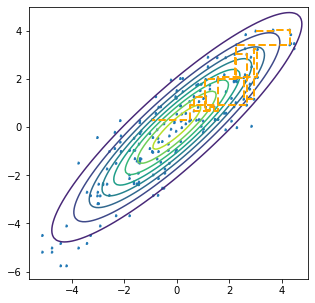

In [37]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(list_sample[:30,0],list_sample[:30,1],ls="dashed",lw=2,color='orange')
ax.scatter(list_sample[:,0],list_sample[:,1],ls="dashed",lw=1,s=4)


x0_line,x1_line = np.meshgrid(np.linspace(-5,5,100),np.linspace(-5,5,100))
x_point = np.dstack((x0_line, x1_line))
density = multivariate_normal(mean=mu_true, cov=sigma_true).pdf(x_point)
cont1 = ax.contour(x0_line,x1_line,density,levels=10)

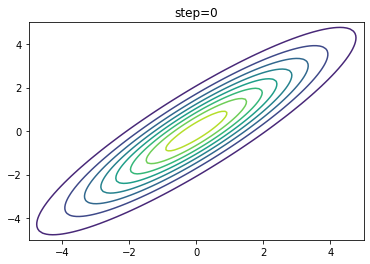

In [39]:
fig, ax = plt.subplots()
x_min, x_max = (-5, 5)
y_min, y_max = (-5, 5)
def update_anim(i):
    plt.cla()
    density = multivariate_normal(mean=mu_true, cov=sigma_true).pdf(x_point)
    im= ax.contour(x0_line,x1_line,density,levels=10)
    ax.scatter(list_sample[:i,0],list_sample[:i,1],marker="x")
    ax.plot(list_sample[:i,0],list_sample[:i,1],marker="x",ls="dashed",lw=2,color='orange')
    
    plt.title(f"step={i}")


anim = FuncAnimation(fig, update_anim, interval=150,frames = 100)
rc('animation', html='jshtml')
anim

# for saving
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg' # For google colab
HTML(anim.to_html5_video())

### 2次元ガウス分布を用いてベイズ推論

#### 問題設定
推論を行いたいパラメータが2次元ガウス分布に従うと仮定してパラメータの分布を推定する.  
実際には2次元ガウス分布は解析的にベイズ推論を行うことができる(3章)が、ここでは真の分布と推定した分布を比べやすいので2次元ガウス分布を扱う。  
（仮に何かしらの理由で2次元ガウス分布からのサンプリングは難しいけど、1次元ガウス分布からはサンプリングできる世界線を考えてください。）

近似推論でないとベイズ推論できない例（混合分布）は以降の章で扱う。
* 4.x.x 混合ポアソン分布でのギブスサンプリング 
* 混合ガウス分布でのギブスサンプリング



#### 2次元ガウス分布のギブスサンプリングでの近似推論
$$
\begin{aligned}
\mathcal{N}(\boldsymbol{x} | \boldsymbol{\mu}, \boldsymbol{\Lambda}) 
&= \mathcal{N}(x_1, x_2 | \boldsymbol{\mu}, \boldsymbol{\Lambda})\\
&= \mathcal{N}( \left(\begin{array}{cc} x_1\\ x_2 \end{array}\right)|  \left(\begin{array}{c} \mu_1\\ \mu_2 \end{array}\right),\left(\begin{array}{cc} \Lambda_{1,1} & \Lambda_{1,1}\\ \Lambda_{1,1} & \Lambda_{1,1} \end{array}\right)^{-1})\\
&=exp\{  \left(\begin{array}{cc} x_1 - \mu_1\\ x_2-\mu_2 \end{array}\right)^T  \left(\begin{array}{cc} \Lambda_{1,1} & \Lambda_{1,1}\\ \Lambda_{1,1} & \Lambda_{1,1} \end{array}\right) \left(\begin{array}{cc} x_1 - \mu_1\\ x_2-\mu_2 \end{array}\right)\}
\end{aligned}
$$

  
**条件付き分布を計算する**  
$x_2^{(n)}$がサンプリングされたときの$x_1$の条件付き事後分布

$$
\begin{aligned}
\mathcal{N}(x_1 |x_2^{(n)}, \boldsymbol{\mu}, \boldsymbol{\Lambda}) 
&\propto \mathcal{N}(x_1,x_2^{(n)}| \boldsymbol{\mu}, \boldsymbol{\Lambda}) \\
&\propto exp\{- \frac{1}{2} \{x_1^2 \Lambda_{1,1} - 2x_1(\Lambda_{1,1} \mu_1 - \Lambda_{1,2}(x_2^{(n)} - \mu_2)) \}\}
\end{aligned}
$$



正規化により1次元ガウス分布を得る  
$$
\begin{aligned}
\mathcal{N}(x_1 |x_2^{n}, \boldsymbol{\mu}, \boldsymbol{\Lambda}) 
= \mathcal{N}(x_1 | m_1, \Lambda_{1,1}^{-1})
\end{aligned}
$$
ただし
$$
m_1 = \mu_1 - \Lambda_{1,1}^{-1} \Lambda_{1,2} (x_2^{(n)}-\mu_2)
$$


正規化部分の解説　PRML 2.71~2.75

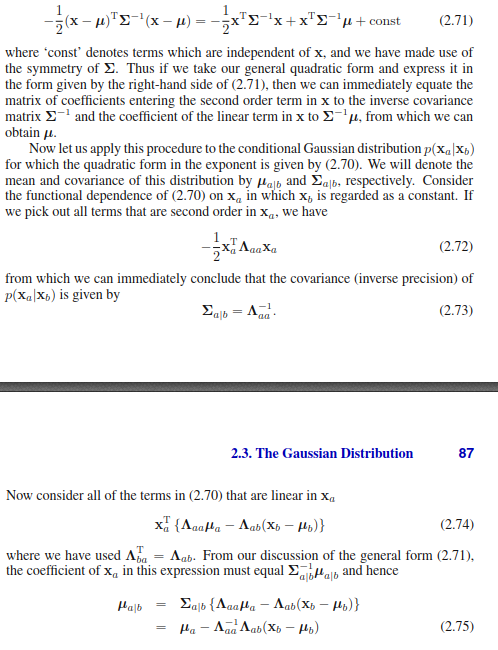

一方得られたサンプリングデータから求めたい分布の統計量（平均、分散）は次のように推定できる。  
（普通にこれまでサンプリングされた値の平均と分散を求めている）
 


$$
\hat{\mu} = \frac{1}{N} \sum_{n=1}^N \left(\begin{array}{cc} x_1^{(n)} \\ x_2^{(n)} \end{array}\right)
$$

$$
\hat{\Lambda}^{-1} = \frac{1}{N} \sum_{n=1}^N \left(\begin{array}{cc} x_1^{(n)} \\ x_2^{(n)} \end{array}\right) \left(\begin{array}{cc} x_1^{(n)} \\ x_2^{(n)} \end{array}\right)^\mathsf{T} - \hat{\mu}\hat{\mu}^\mathsf{T}
$$

#### 実装

真の分布を設定

In [45]:
mu_true = np.array([-1.0,1.0])
lambda_true = np.array([[1.0,0.5],
                   [0.5,1.0]])
sigma_true = np.linalg.inv(lambda_true)

In [46]:
x_min, x_max = (-5, 5)
y_min, y_max = (-5, 5)
x0_line,x1_line = np.meshgrid(np.linspace(-5,5,100),np.linspace(-5,5,100))
x_point = np.dstack((x0_line, x1_line))
density = multivariate_normal(mean=mu_true, cov=sigma_true).pdf(x_point)

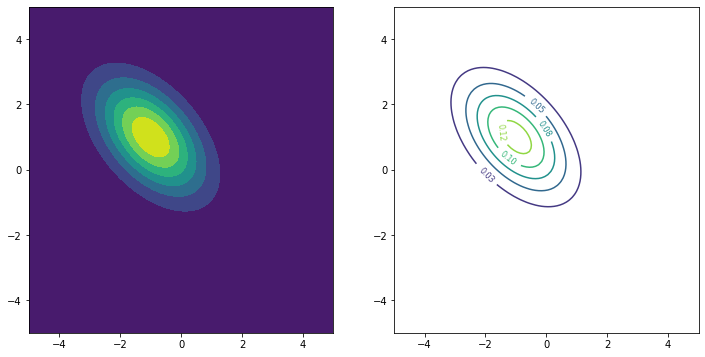

In [47]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
axs[0].contourf(x0_line,x1_line,density)
axs[0].set_xlim(x_min,x_max)
axs[0].set_ylim(y_min,y_max)

cont = axs[1].contour(x0_line,x1_line,density,levels=5)
cont.clabel(fmt='%1.2f',fontsize=8)
axs[1].set_xlim(x_min,x_max)
axs[1].set_ylim(y_min,y_max)

plt.show()

ベイズ推論

In [48]:
# setup params
step = 100

In [49]:
# initialize
x = [3,4]
mu_hat = np.array([0,0])  # 平均推定値
lambda_hat = np.array([[1., 1.5],
                       [1.5, 1.]]) # 分散推定値
history = {
    "x":[[1,1],[1,2],x.copy()],
    "mu_hat":[mu_hat.copy(),mu_hat.copy(),mu_hat.copy()],
    "lambda_hat":[lambda_hat.copy(),lambda_hat.copy(),lambda_hat.copy()]
}


for i in range(step):
    ##### Sample x0 #####
    # calculate conditional probability
    m = mu_true[0] - 1/lambda_true[0,0] * lambda_true[0,1] * (x[1] - mu_true[1])
    sigma = 1/lambda_true[0,0]
    x[0]= np.random.normal(m,sigma) 
    history["x"].append(x.copy())

    # cal mu_hat, lambda_hat
    mu_hat = np.mean(history["x"],axis=0)
    lambda_hat = np.linalg.inv(np.cov(np.array(history["x"]).T))
    history["mu_hat"].append(mu_hat.tolist())
    history["lambda_hat"].append(lambda_hat.tolist())


    ##### Sample x1 #####
    # calculate conditional probability
    m = mu_true[1] - 1/lambda_true[1,1] * lambda_true[1,0] * (x[0] - mu_true[0]) 
    sigma =  1/lambda_true[1,1]
    x[1]= np.random.normal(m,sigma)
    history["x"].append(x.copy())

    # cal mu_hat, lambda_hat
    mu_hat = np.mean(history["x"],axis=0)
    lambda_hat = np.linalg.inv(np.cov(np.array(history["x"]).T))
    history["mu_hat"].append(mu_hat.tolist())
    history["lambda_hat"].append(lambda_hat.tolist())

history["x"] = np.array(history["x"])
history["mu_hat"] = np.array(history["mu_hat"])
history["lambda_hat"] = np.array(history["lambda_hat"])

In [54]:
print(f"平均: {mu_true},\n 精度:{lambda_true}")
print(f"推定平均: {mu_hat},\n 推定精度:{lambda_hat}")


平均: [-1.  1.],
 精度:[[1.  0.5]
 [0.5 1. ]]
推定平均: [-0.88897916  0.9437237 ],
 推定精度:[[0.82988172 0.39385911]
 [0.39385911 0.93563132]]


(-5.0, 5.0)

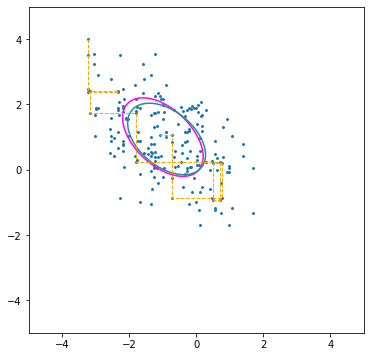

In [56]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
density = multivariate_normal(mean=mu_true, cov=sigma_true).pdf(x_point)
cont0 = ax.contour(x0_line,x1_line,density,levels=1,colors=["magenta"])
# cont0.clabel(fmt='%1.2f',fontsize=8)

density = multivariate_normal(mean=mu_hat, cov=np.linalg.inv(lambda_hat)).pdf(x_point)
cont1 = ax.contour(x0_line,x1_line,density,levels=1)
# cont1.clabel(fmt='%1.2f',fontsize=8)

ax.scatter(history["x"][3:,0],history["x"][3:,1],marker="x",s=4)
ax.plot(history["x"][3:20,0],history["x"][3:20,1],ls="--",lw=1,color="orange")

ax.set_xlim(x_min,x_max)
ax.set_ylim(y_min,y_max)

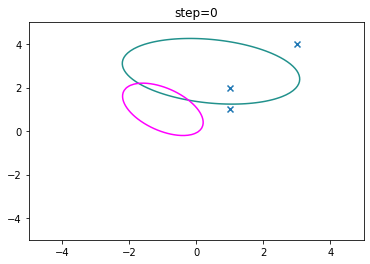

In [57]:
fig, ax = plt.subplots()
def update_anim(i):
    plt.cla()
    mu_hat = history["mu_hat"][i+3]
    lambda_hat = history["lambda_hat"][i+3]
    x = history["x"][i+3]
    density = multivariate_normal(mean=mu_hat, cov=np.linalg.inv(lambda_hat)).pdf(x_point)
    im = plt.contour(x0_line,x1_line,density,levels=1)
    density = multivariate_normal(mean=mu_true, cov=np.linalg.inv(lambda_true)).pdf(x_point)
    im = plt.contour(x0_line,x1_line,density,levels=1,colors=["magenta"])

    ax.scatter(history["x"][:i+3,0],history["x"][:i+3,1],marker="x")

    plt.title(f"step={i}")


anim = FuncAnimation(fig, update_anim, interval=150,frames = 100)
rc('animation', html='jshtml')
anim
HTML(anim.to_html5_video())

## 参考資料

* https://machine-learning.hatenablog.com/entry/2016/02/04/201945
* https://research.miidas.jp/2019/12/mcmc%E5%85%A5%E9%96%80-gibbs-sampling/
* PRML 2章, 11章